<h2>OBSERVATIONAL ASTROPHYSICS – FALL 2019 Reduction Exercise: Part 5</h2>

The goal of this part is to produce a color-magnitude diagram for your cluster.  Do do this we need to detect stars, measure their flux, compare it to a known magnitude for that star, derive the magnitude zeropoint for that band, and convert all of your fluxes to magnitudes.  This will be broked into the following steps:

1. read in image with a valid astrometric header (the output image from the end of part 4);
2. Locate stars in this image and measure their flux;
3. Read in an ASCII file with a list of measured magnitudes for stars in that cluster;
4. Cross-match the two lists to find which object corresponds to which;
5. Compare the fluxes and magnitudes to determine the magnitude zeropoint of your image, i.e. what magnitude is a single count;
6. Use this to create magnitudes in each band
7. Produce a color-magnitude diagrame

The first cell below is a routine designed to read in one image

In [1]:
import os, glob, time
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from astropy import units as u

redpath = "/home/m044e358/ASTR596/Data/Reduced/"

A routine to display in image

In [2]:
def display_image(img, minclip=5, maxclip=95, label=None, cmap='Greys_r', 
                  srcs=None, projection=None, calibrated=False):
    """Simple wrapper to display an image.
    
    """
    from astropy.visualization import AsinhStretch as Stretch
    from astropy.visualization import ZScaleInterval as Interval
    from astropy.visualization.mpl_normalize import ImageNormalize

    #from astropy.visualization import simple_norm
    #norm = simple_norm(img, min_percent=minclip, max_percent=maxclip)

    interval = Interval(contrast=0.5)
    vmin, vmax = interval.get_limits(img)
    norm = ImageNormalize(interval=interval, stretch=Stretch(a=0.9))

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': projection})
    im = ax.imshow(img, origin='lower', norm=norm, cmap=cmap,
                   vmin=vmin, vmax=vmax)
    if projection:
        ax.coords.grid(color='red')
        ax.coords['ra'].set_axislabel('Right Ascension')
        ax.coords['dec'].set_axislabel('Declination')      
    else:
        ax.set_xlabel('Column Number (pixels)')
        ax.set_ylabel('Row Number (pixels)')

    # Mark the locations of stars.
    if srcs:
        from photutils import CircularAperture
        pos = np.transpose((srcs['xcentroid'], srcs['ycentroid']))
        aps = CircularAperture(pos, r=12.)
        aps.plot(color='red', lw=1.5, alpha=0.6, axes=ax)
      
    # Make room for the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.28, 0.05, 0.45])
    c = plt.colorbar(im, cax=cax)
    if label:
        c.set_label(label)
    else:
        if calibrated:
            c.set_label(r'Intensity ($e^{-}/s$)')
        else:
            c.set_label('Intensity (ADU)')

<h3> Find the stars in your image</h3>

In [3]:
#filename should be the name of the combined image file (without path) that has the original header
#wcsfilename should be the name of the image that has the correct WCS header, e.g. one output
#by astrometry.net. 
def read_one_image(filename, wcsfilename, redpath):
    from astropy.table import Table
    from astropy.wcs import WCS

    # This joins the path and the filename
    imgfile = os.path.join('{}'.format(redpath), filename)
    wcsfile = os.path.join('{}'.format(redpath), wcsfilename)

    print('Reading {}'.format(imgfile))
    #this is the image and full header of the file.  
    img, hdr = fits.getdata(imgfile, header=True)
    wcshdr = fits.getheader(wcsfile)

    #this is only the section of the file that contains the WCS, which is the mapping between pixel 
    #and sky coordinate (RA,DEC)
    imgwcs = WCS(wcshdr)#, naxis=2)

    return img, hdr, imgwcs, imgfile

In [4]:
img_ngc7296_V, hdr_ngc7296_V, imgwcs_ngc7296_V, imgfile_ngc7296_V = read_one_image('NGC7296_V_comb.fits','wNGC7296_V_comb.fits',redpath)
img_ngc7296_B, hdr_ngc7296_B, imgwcs_ngc7296_B, imgfile_ngc7296_B = read_one_image('NGC7296_B_comb.fits','wNGC7296_B_comb.fits',redpath)

img_k20_V, hdr_k20_V, imgwcs_k20_V, imgfile_k20_V = read_one_image('K20_V_comb.fits','wK20_V_comb.fits',redpath)
img_k20_B, hdr_k20_B, imgwcs_k20_B, imgfile_k20_B = read_one_image('K20_B_comb.fits','wK20_B_comb.fits',redpath)



Reading /home/m044e358/ASTR596/Data/Reduced/NGC7296_V_comb.fits
Reading /home/m044e358/ASTR596/Data/Reduced/NGC7296_B_comb.fits
Reading /home/m044e358/ASTR596/Data/Reduced/K20_V_comb.fits
Reading /home/m044e358/ASTR596/Data/Reduced/K20_B_comb.fits


This is the same routine that we used in part 4.  It measures the background.

In [5]:
def get_sky_background(img, verbose=True):
    from astropy.stats import SigmaClip
    from photutils import Background2D, MedianBackground
    sigma_clip = SigmaClip(sigma=4.)
    bkg = Background2D(img, (100, 100), filter_size=(10, 10), sigma_clip=sigma_clip, 
                       bkg_estimator=MedianBackground())
    if verbose:
        print('Sky background median = {:.3f}, rms = {:.3f} electrons.'.format(bkg.background_median, bkg.background_rms_median))
    return bkg

This gets the background and subtracts it from the image to get a background subtracted image.  As in part 4 we check that the background looks correct.

In [6]:
#***********
bkg_V = get_sky_background(img_ngc7296_V, verbose=True)
img_ngc7296_V_nosky = img_ngc7296_V - bkg_V.background

bkg_B = get_sky_background(img_ngc7296_B, verbose=True)
img_ngc7296_B_nosky = img_ngc7296_B - bkg_B.background

bkgk20_V = get_sky_background(img_k20_V, verbose=True)
img_k20_V_nosky = img_k20_V - bkgk20_V.background

bkgk20_B = get_sky_background(img_k20_B, verbose=True)
img_k20_B_nosky = img_k20_B - bkgk20_B.background



Sky background median = 2.199, rms = 0.063 electrons.
Sky background median = 1.921, rms = 0.053 electrons.
Sky background median = 2.002, rms = 0.050 electrons.
Sky background median = 1.714, rms = 0.045 electrons.


In [7]:
def qa_background(img,img_nosky,bkg):
    med, sig = bkg.background_median, bkg.background_rms_median
    vrange = (-3*sig, med+5*sig)
    fig, ax = plt.subplots(figsize=(7, 5))
    _ = ax.hist(img.flatten(), bins=100, range=vrange, label='Image w/ Background')
    #_ = ax.hist(bkg.background.flatten(), bins=50, range=(-sig, med+5*sig), label='Background')
    _ = ax.hist(img_nosky.flatten(), bins=100, range=vrange, label='Image w/o Background')
    ax.axvline(x=bkg.background_median, lw=2, ls='-', color='k')
    ax.set_xlabel('Intensity (e-/s)')
    ax.set_ylabel('Number')
    ax.legend(fontsize=12, frameon=False)

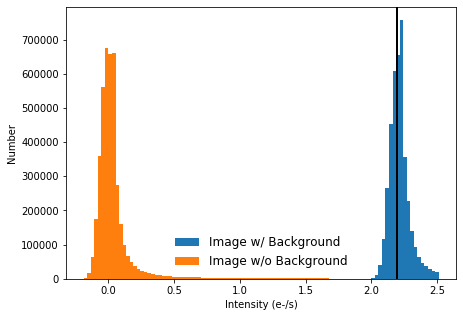

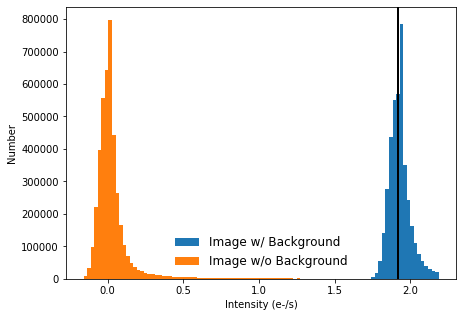

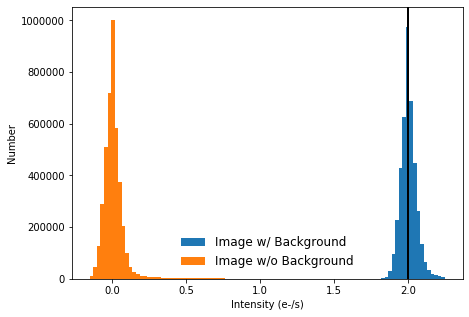

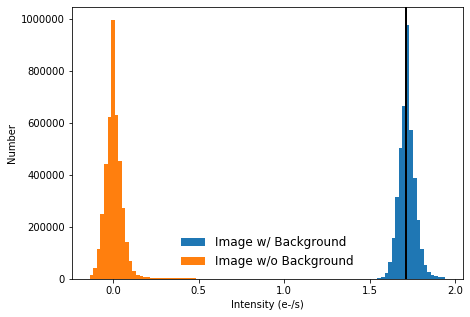

In [8]:
#***********
qa_background(img_ngc7296_V, img_ngc7296_V_nosky,bkg_V)
qa_background(img_ngc7296_B, img_ngc7296_B_nosky,bkg_B)

qa_background(img_k20_V, img_k20_V_nosky,bkgk20_V)
qa_background(img_k20_B, img_k20_B_nosky,bkgk20_B)



This routine detects stars in the image.  It requires a zero background image.  There are many ways to measure object flux.  We are using the DAOStarfinder algorithm described (https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html)

This code requires as input the FWHM of stars in the image in pixel units.  You can determine this using the *imexam* task.

You can use this by going to your image directory and typing *ipython* at the command line.  Once the interactive python environment loads you type the following set of commands:

*import imexam*
*viewer=imexam.connect()*
*viewer.load_fits('<filename>')*
*viewer.scale()*
    
You can then hit the "a" key and "r" key on bright isolated and unsaturated stars to find the FWHM.

If imexam doesn't work on your computer then just use the mean FWHM from all the individual observations for that band/target

This will need to be run once for each band

In [9]:
#this code outputs a file with all the detected stars.
#fwhm is for stars in the image in units of pixels
#nsigma is the detection threshold for each star
def find_stars(image, imgfile, fwhm=3.0, nsigma=3, sigma=None, 
               verbose=True, overwrite=False):
    from astropy.table import Table
    
    #this makes a file 
    starsfile = os.path.join(redpath, 'stars-{}'.format(os.path.basename(imgfile)))
    if not os.path.isfile(starsfile) or overwrite:
        from photutils import DAOStarFinder
        if sigma is None:
            sigma = np.std(image)

        daofind = DAOStarFinder(fwhm=fwhm, threshold=nsigma * sigma)
        srcs = daofind(image)
        # reverse-sort by flux 
        srcs.sort('flux')
        srcs.reverse()
        if verbose:
            print('Found {} sources'.format(len(srcs)))

        print('Writing {} stars to {}'.format(len(srcs), starsfile))
        srcs.write(starsfile, overwrite=True)
    else:
        srcs = Table.read(starsfile)
        print('Read {} stars from {}'.format(len(srcs), starsfile))
    return srcs

In [10]:
#***********
srcs_ngc7296_V = find_stars(img_ngc7296_V_nosky, imgfile_ngc7296_V, sigma=bkg_V.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_ngc7296_V

Read 2308 stars from /home/m044e358/ASTR596/Data/Reduced/stars-NGC7296_V_comb.fits


<Table length=2308>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
    4 1527.0421000506708 ...  2613.375780183206      -8.54300465474896
 1050 1162.5727292604624 ...  2271.295147056806     -8.390683932433348
 1679  2040.114920515802 ... 2025.5105626535196     -8.266336280722218
 1860 335.77471180489476 ...  2010.097471010128     -8.258042792923728
 1592 1764.1588301149327 ... 1982.2738093970936     -8.242909107332206
 1920 1103.4698222928491 ... 1799.7575251104067     -8.138034995258337
  434 1174.2240253012717 ... 1656.0856893911723     -8.047707010872983
 1677 1168.3395220447467 ... 1582.4931946062727     -7.998354627606108
 1507  322.9576962489579 ... 1398.3988272678466     -7.864077627700725
 1505 323.44400265008414 ...  1367.888395181183     -7.840126662805641
  ...                ... ...                ...                    ...
 1024  1269.207814491524 ...  1.007484790300243  -0.008096246118385903
 1601 1036.1508656540275 ... 1.0056047777147261  -0.006068320133030368
 1716 1847.3196938613887 ...   1.00522207754438  -0.005655045927504522
 1384 1035.3138903758515 ... 1.0044375218081074  -0.004807319664737818
 2305  920.1435436955039 ... 1.0042300746706307  -0.004583058697988049
  344  819.8345169463331 ... 1.0037476356494854  -0.004061338243391054
 1438  68.93772624628372 ... 1.0025054200435368 -0.0027168232770249548
  167  740.7107080327489 ... 1.0017561034956879 -0.0019049929513179618
 2307  170.2062231647022 ...  1.001342597130275  -0.001456728631577867
  478  1320.881108315472 ... 1.0007980901240907 -0.0008661697475816038

In [11]:
srcs_ngc7296_B = find_stars(img_ngc7296_B_nosky, imgfile_ngc7296_B, sigma=bkg_B.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_ngc7296_B

Read 2064 stars from /home/m044e358/ASTR596/Data/Reduced/stars-NGC7296_B_comb.fits


<Table length=2064>
  id      xcentroid      ...        flux                  mag          
int64      float64       ...      float64               float64        
----- ------------------ ... ------------------ -----------------------
    7  1527.201607474176 ...  3417.078116796757      -8.834137267969975
 1517 2039.9978634869951 ... 2520.6155420224145        -8.5037665244341
 1515 1168.3306254311844 ... 2265.3086354156544      -8.387818451331864
 1728 1103.5461084961291 ...   2056.49535718896      -8.282819333422259
 1023  993.5177045406763 ... 1894.1208881934751      -8.193519233658545
 1441 1764.1064440191478 ...  1865.041318450871      -8.176721144217584
  959 1162.7997454277465 ... 1835.8765124669847       -8.15960866417041
 1369  322.9650551510611 ... 1777.4844573460257      -8.124514529667143
  974  730.6838485682397 ... 1671.7475319576888      -8.057926726781762
 1057   850.110060980453 ... 1651.9128069018984      -8.044967800438013
  ...                ... ...                ...                     ...
  388 1207.6198838718356 ... 1.0060162911121246  -0.0065125340135219634
 1965  1545.350431267166 ...  1.005448001768192    -0.00589903832872489
 1299  669.9584344833593 ...  1.004747279792454  -0.0051420976908453115
  132 1132.9474505931587 ... 1.0041890135216158   -0.004538664003312241
 1847 1152.5664239808311 ... 1.0034252809112132  -0.0037125967769843474
  124 213.29792041085634 ... 1.0012787875357079  -0.0013875389309321545
  493 1134.3065583516398 ... 1.0009020639123585   -0.000978961971873592
   96  987.4881266746326 ...  1.000729865275448  -0.0007921521071439972
 1056 1400.2118062821621 ... 1.0005669275025086  -0.0006153592993684196
 1901  258.3475703447109 ... 1.0001712303447114 -0.00018589506962217044

In [12]:
srcs_k20_V = find_stars(img_k20_V_nosky, imgfile_k20_V, sigma=bkgk20_V.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_k20_V

Read 1287 stars from /home/m044e358/ASTR596/Data/Reduced/stars-K20_V_comb.fits


<Table length=1287>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
  506   87.2182859139273 ...  2987.704274574263     -8.688344021114347
  331 1824.8920796576397 ...   2502.03311792601      -8.49573263473376
  670  999.9501256707265 ... 2282.8902537978483     -8.396212584994066
  652 1301.2627476796633 ... 2222.0128830209624     -8.366866431526406
  755 1348.7066324148418 ... 2121.1094091754226      -8.31640767621323
  105 1302.7907636207365 ... 1963.9287753767176     -8.232814333599624
  503  86.72932021955307 ... 1845.4302192392856     -8.165244069951815
  504  87.43501210936675 ... 1724.0628357309095     -8.091382725522632
  920 236.46020396276697 ...  1456.517912330909    -7.9082895749300475
  873 1015.3487068977639 ... 1445.8816709073033     -7.900331880780129
  ...                ... ...                ...                    ...
  193 1620.4149484195784 ... 1.0082856850781914  -0.008959003573162972
  663 1290.8397568043515 ... 1.0078722445984312  -0.008513713750304403
   99  531.9232847442235 ... 1.0068694066289636  -0.007432862932321061
 1161  288.8718603111383 ... 1.0062696056973102  -0.006785887634116406
  179   952.289269893646 ... 1.0061647293641565   -0.00667272316455188
  930  726.9770539897349 ... 1.0038352010493954  -0.004156052068682546
 1001 203.01125478133355 ... 1.0037035408263273  -0.004013640599220245
    6  410.4092873191115 ... 1.0033393505978632   -0.00361961362302354
 1143  948.9547231555059 ... 1.0033084998153912 -0.0035862287802662907
  293  767.9146681235488 ... 1.0030231162080507  -0.003277355297588675

In [13]:
srcs_k20_B = find_stars(img_k20_B_nosky, imgfile_k20_B, sigma=bkgk20_B.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_k20_B

Read 697 stars from /home/m044e358/ASTR596/Data/Reduced/stars-K20_B_comb.fits


<Table length=697>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
  262  87.07575568718738 ... 2120.7860033254306     -8.316242121239943
  355  999.9723011276989 ... 2027.4190045723942     -8.267358782892451
  173 1824.9080272426693 ... 1356.3588006240757      -7.83093647404689
  343 1301.2582041141868 ... 1320.3998871770318     -7.801763696373808
  652  789.1201169928217 ...  886.3591090142247     -7.369024280636221
  478 1015.3789862534309 ...  867.9794714406581     -7.346273634526851
   63  486.9825455113836 ...  703.9956734255271     -7.118924975223203
  510  236.4709428654562 ...  608.4215265589138     -6.960511428559086
   45 1302.9039392351024 ...  545.2064154685809     -6.841402393888848
  237  800.2534378538405 ... 430.94433685137284     -6.586052944778492
  ...                ... ...                ...                    ...
  658  858.2661324756733 ...  1.016781093565595   -0.01806865543924744
  151  858.3778807835012 ... 1.0152550838685892   -0.01643793222012606
  567 1394.5084275661525 ... 1.0152060946434194  -0.016385540796952702
  130  1436.953378911385 ... 1.0111882482366046  -0.012080034278991882
  451 1774.1001389546855 ... 1.0106240598584264   -0.01147408311137944
  212  1431.590723098796 ...  1.007419749670597  -0.008026151515876788
  183 1035.7543881864817 ...  1.006228496338623  -0.006741530902507955
  264   475.186886412313 ... 1.0062121523768246  -0.006723895370185135
  674 1755.4471307906667 ... 1.0052866144925545  -0.005724749780543483
  299  747.5114106128631 ...  1.001804562155824 -0.0019575127703143373

<h3> Use stars from Pan-STARRS</h3>

We will be using the large survey called Pan-STARRS (https://panstarrs.stsci.edu/).  Pan-STARRS uses SDSS filters (*griz*), which are different from the "Johnson" *BVR* filters that we are using.  But there are transformation between these filters such that if we know the Pan-STARRS magnitudes of a given object, we can determine its B-V color.

This routine sends a request to a catalog server at a remote location and pulls back all the photometry

In [14]:
def get_panstarrs_catalog(imgwcs, radius=0.2, rfaint=17, region=False):
    from astroquery.mast import Catalogs
    ra0, dec0 = imgwcs.wcs.crval
    print('Querying Pan-STARRS catalog with radius={:.3f} deg and central coordinates RA,Dec={:.5f},{:.5f}'.format(
        radius, ra0, dec0))
    if region:
        allcat = Catalogs.query_region('{} {}'.format(ra0, dec0), radius=radius,
                                       catalog='PANSTARRS', data_release='dr2', 
                                       table='mean')#, rMeanPSFMag=[12, 22])
    else:
        allcat = Catalogs.query_criteria(coordinates='{} {}'.format(ra0, dec0), radius=radius,
                                         catalog='PANSTARRS', data_release='dr2', 
                                         table='mean',
                                         columns=['objID', 'raMean', 'decMean',
                                                  'gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag', 'zMeanPSFMag'],
                                         gMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         rMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         iMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         zMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         sort_by=[("asc", "rMeanPSFMag")])
    

    #we limit ourselves to bright objects so that we know that they will have high Signal-to-Noise
    rmag = allcat['rMeanPSFMag']
    good = np.isfinite(rmag) * rmag < rfaint
    cat = allcat[good]
    print('Keeping {}/{} Pan-STARRS sources with rmag< {}.'.format(len(cat), len(allcat),rfaint))
    
    #make B and V-band magnitudes using the transformations published in Tonry et al. (2012)
    #https://ui.adsabs.harvard.edu/abs/2012ApJ...750...99T/abstract
    cat['B'] = 0.213 + 0.587 * (cat['gMeanPSFMag'] - cat['rMeanPSFMag']) + cat['gMeanPSFMag'] 
    cat['V'] = 0.006 + 0.474 *  (cat['gMeanPSFMag'] - cat['rMeanPSFMag']) + cat['rMeanPSFMag'] 
    
    return cat

In [15]:
%time refcat_ngc7296_V = get_panstarrs_catalog(imgwcs_ngc7296_V, radius=0.2)
refcat_ngc7296_V

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=336.99850,52.31030


Keeping 1876/2429 Pan-STARRS sources with rmag< 17.
CPU times: user 408 ms, sys: 74 ms, total: 482 ms
Wall time: 9.4 s


<Table masked=True length=1876>
      objID           raMean    ...         B                  V         
      int64          float64    ...      float64            float64      
------------------ ------------ ... ------------------ ------------------
170943372203227812  337.2202993 ...  12.88981902885437 12.307738147735595
170743370290958728 337.02906732 ... 12.126145251274108  12.10279020881653
170943372207347564 337.22056658 ... 14.244887639045714 12.786876089096069
170863369192465163 336.91918882 ... 13.060515614509583 12.469530317306518
170943368790368268  336.8790098 ... 12.943077045440674 12.434454147338867
170543370161030664 337.01602855 ... 12.799398455619812 12.420996141433715
170703370181676873  337.0181369 ... 12.874226049423218 12.446852100372315
170783369969459393 336.99703351 ... 12.345581248283386 12.291062341690063
170603371602172578 337.16019335 ... 12.629327228546142 12.398954330444337
170643371551096914 337.15517921 ... 13.524848155021667 12.683327043533325
               ...          ... ...                ...                ...
170623368332659031 336.83321799 ...  18.44889137840271 17.369521839141846
170573371289831728 337.12895313 ... 18.079284210205078 17.259689254760744
170653367874153919 336.78737922 ... 18.289251417160035 17.322963397979738
170793370210802545 337.02104502 ...  18.56670211982727 17.407864727020264
170793370687883790 337.06880066 ...  18.23906773376465 17.310288864135742
170793369904373426 336.99041919 ...  18.16234239768982 17.287652362823486
170663369303064830 336.93028874 ...  18.04202839279175 17.251928718566894
170653371451185125  337.1450969 ...  18.16781915664673 17.289569053649902
170803372199494622 337.21991001 ... 17.981613805770873 17.234585224151612
170773372007782560 337.20075526 ...  17.96003767967224 17.228701419830323

In [16]:
%time refcat_ngc7296_B = get_panstarrs_catalog(imgwcs_ngc7296_B, radius=0.2)
refcat_ngc7296_B

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=336.99851,52.31030
Keeping 1876/2429 Pan-STARRS sources with rmag< 17.
CPU times: user 31.9 ms, sys: 4 ms, total: 35.9 ms
Wall time: 3.19 s


<Table masked=True length=1876>
      objID           raMean    ...         B                  V         
      int64          float64    ...      float64            float64      
------------------ ------------ ... ------------------ ------------------
170943372203227812  337.2202993 ...  12.88981902885437 12.307738147735595
170743370290958728 337.02906732 ... 12.126145251274108  12.10279020881653
170943372207347564 337.22056658 ... 14.244887639045714 12.786876089096069
170863369192465163 336.91918882 ... 13.060515614509583 12.469530317306518
170943368790368268  336.8790098 ... 12.943077045440674 12.434454147338867
170543370161030664 337.01602855 ... 12.799398455619812 12.420996141433715
170703370181676873  337.0181369 ... 12.874226049423218 12.446852100372315
170783369969459393 336.99703351 ... 12.345581248283386 12.291062341690063
170603371602172578 337.16019335 ... 12.629327228546142 12.398954330444337
170643371551096914 337.15517921 ... 13.524848155021667 12.683327043533325
               ...          ... ...                ...                ...
170623368332659031 336.83321799 ...  18.44889137840271 17.369521839141846
170573371289831728 337.12895313 ... 18.079284210205078 17.259689254760744
170653367874153919 336.78737922 ... 18.289251417160035 17.322963397979738
170793370210802545 337.02104502 ...  18.56670211982727 17.407864727020264
170793370687883790 337.06880066 ...  18.23906773376465 17.310288864135742
170793369904373426 336.99041919 ...  18.16234239768982 17.287652362823486
170663369303064830 336.93028874 ...  18.04202839279175 17.251928718566894
170653371451185125  337.1450969 ...  18.16781915664673 17.289569053649902
170803372199494622 337.21991001 ... 17.981613805770873 17.234585224151612
170773372007782560 337.20075526 ...  17.96003767967224 17.228701419830323

In [17]:
%time refcat_k20_V = get_panstarrs_catalog(imgwcs_k20_V, radius=0.2)
refcat_k20_V

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=353.31950,58.47552
Keeping 643/652 Pan-STARRS sources with rmag< 17.
CPU times: user 26.8 ms, sys: 303 µs, total: 27.1 ms
Wall time: 3.99 s


<Table masked=True length=643>
      objID           raMean    ...         B                  V         
      int64          float64    ...      float64            float64      
------------------ ------------ ... ------------------ ------------------
177973533643142604 353.36438085 ... 13.106981146812439 12.278481775283813
178253534222408649 353.42222936 ... 13.765923689842225 12.689336183547974
178063533638825273  353.3639764 ...  13.02220694923401 12.524714305877685
178193533621090461 353.36215886 ... 13.630024438858031 12.808648387908935
178003535709165660 353.57091598 ...  13.43149608707428 12.770392095565796
178243534353808280 353.43544285 ... 14.003855922698975 13.031112228393555
177973531027574158 353.10279647 ... 13.910222898483276 13.003146221160888
177943533354839104 353.33555251 ... 15.151532992362975 13.575877855300904
178283534833775064 353.48342907 ...   13.9078879737854 13.228976211547852
178203532822397719 353.28226479 ... 13.870125274658204 13.245750274658203
               ...          ... ...                ...                ...
178303533587926326 353.35876197 ...  18.75672840118408 17.440846786499023
178103532385686076 353.23854466 ... 18.719216722488405 17.436725872039794
178303530050130860 353.00500804 ...  18.55760074234009   17.3936450881958
177953533551475774 353.35513306 ...  18.26874841117859 17.308913944244384
178283536222115729   353.622211 ... 17.761384883880616  17.15927039337158
178053535274722220 353.52743711 ...  18.70315467262268 17.444482524871827
178043533328551756 353.33284466 ...  18.74243766593933 17.456495014190672
177973531140951246 353.11407417 ... 18.519226211547853 17.391440170288085
178183532549873352 353.25495598 ...   18.7033556060791 17.447908111572264
178123531943045190 353.19428958 ... 18.778003078460692 17.472026817321776

In [18]:
%time refcat_k20_B = get_panstarrs_catalog(imgwcs_k20_B, radius=0.2)
refcat_k20_B

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=353.31951,58.47552
Keeping 643/652 Pan-STARRS sources with rmag< 17.
CPU times: user 23.4 ms, sys: 3.68 ms, total: 27 ms
Wall time: 2.69 s


<Table masked=True length=643>
      objID           raMean    ...         B                  V         
      int64          float64    ...      float64            float64      
------------------ ------------ ... ------------------ ------------------
177973533643142604 353.36438085 ... 13.106981146812439 12.278481775283813
178253534222408649 353.42222936 ... 13.765923689842225 12.689336183547974
178063533638825273  353.3639764 ...  13.02220694923401 12.524714305877685
178193533621090461 353.36215886 ... 13.630024438858031 12.808648387908935
178003535709165660 353.57091598 ...  13.43149608707428 12.770392095565796
178243534353808280 353.43544285 ... 14.003855922698975 13.031112228393555
177973531027574158 353.10279647 ... 13.910222898483276 13.003146221160888
177943533354839104 353.33555251 ... 15.151532992362975 13.575877855300904
178283534833775064 353.48342907 ...   13.9078879737854 13.228976211547852
178203532822397719 353.28226479 ... 13.870125274658204 13.245750274658203
               ...          ... ...                ...                ...
178303533587926326 353.35876197 ...  18.75672840118408 17.440846786499023
178103532385686076 353.23854466 ... 18.719216722488405 17.436725872039794
178303530050130860 353.00500804 ...  18.55760074234009   17.3936450881958
177953533551475774 353.35513306 ...  18.26874841117859 17.308913944244384
178283536222115729   353.622211 ... 17.761384883880616  17.15927039337158
178053535274722220 353.52743711 ...  18.70315467262268 17.444482524871827
178043533328551756 353.33284466 ...  18.74243766593933 17.456495014190672
177973531140951246 353.11407417 ... 18.519226211547853 17.391440170288085
178183532549873352 353.25495598 ...   18.7033556060791 17.447908111572264
178123531943045190 353.19428958 ... 18.778003078460692 17.472026817321776

We need to match the Pan-STARRS catalog against ours.  First we need to compute the nearest Pan-STARRS star to each of ours and look at the distribution of distances to find the optimal match.

In [19]:
def sep_check(imgwcs,srcs,refcat):
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    
    #this makes an instance of a SkyCoord class containing the RAs and Decs from Pan-STARRS objects
    refcoord = SkyCoord(ra=refcat['raMean']*u.deg, dec=refcat['decMean']*u.deg)
    #This uses the WCS to convert the x and y positions of stars in our image to RA-DEC
    radec_stars = imgwcs.all_pix2world(srcs['xcentroid']+1, srcs['ycentroid']+1, 1)
    #this does the same from our targets 
    coord = SkyCoord(ra=radec_stars[0]*u.deg, dec=radec_stars[1]*u.deg)

    #this calculates the separations.  The "_" are values that are thrown away
    _, sep2d, _ = coord.match_to_catalog_sky(refcoord)

    #plot the histograms
    _ = plt.hist(sep2d.arcsec, bins=100, range=(-0.5, 3))
    return refcoord, coord

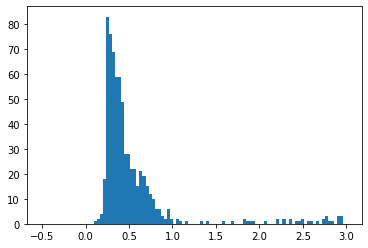

In [20]:
refcoord_ngc7296_V, coord_ngc7296_V = sep_check(imgwcs_ngc7296_V,srcs_ngc7296_V,refcat_ngc7296_V)

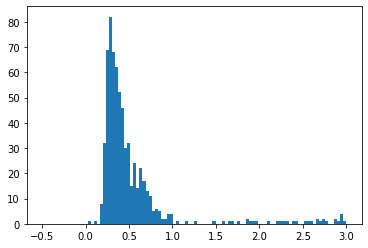

In [21]:
refcoord_ngc7296_B, coord_ngc7296_B = sep_check(imgwcs_ngc7296_B,srcs_ngc7296_B,refcat_ngc7296_B)

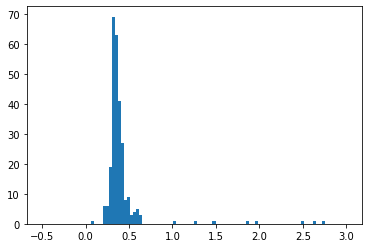

In [22]:
refcoord_k20_V, coord_k20_V = sep_check(imgwcs_k20_V,srcs_k20_V,refcat_k20_V)

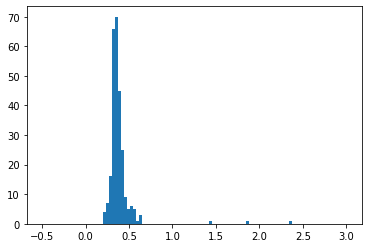

In [23]:
refcoord_k20_B, coord_k20_B = sep_check(imgwcs_k20_B,srcs_k20_B,refcat_k20_B)

It looks like the optimal match is less than 1.0 arcsec.  The following routine matches to within this tolerance

In [24]:
#take two lists of coordinates 
def match_src_ref(refcoord, coord, srcs, img, radasec = 1.0):
    rad = radasec * u.arcsec

    #find the indices of the reference and source list that correspond to matching objects such that
    #the first index in each list corresponds to the first matching object
    indx_ref, indx, d2d, _ = coord.search_around_sky(refcoord, rad)
    nmatch = len(indx_ref)
    print('Found {}/{} stars within {}'.format(nmatch, len(srcs), rad))
    display_image(img, srcs=srcs[indx], calibrated=True)
    return indx, indx_ref

Found 638/2308 stars within 1.0 arcsec
Found 627/2064 stars within 1.0 arcsec
Found 264/1287 stars within 1.0 arcsec
Found 262/697 stars within 1.0 arcsec


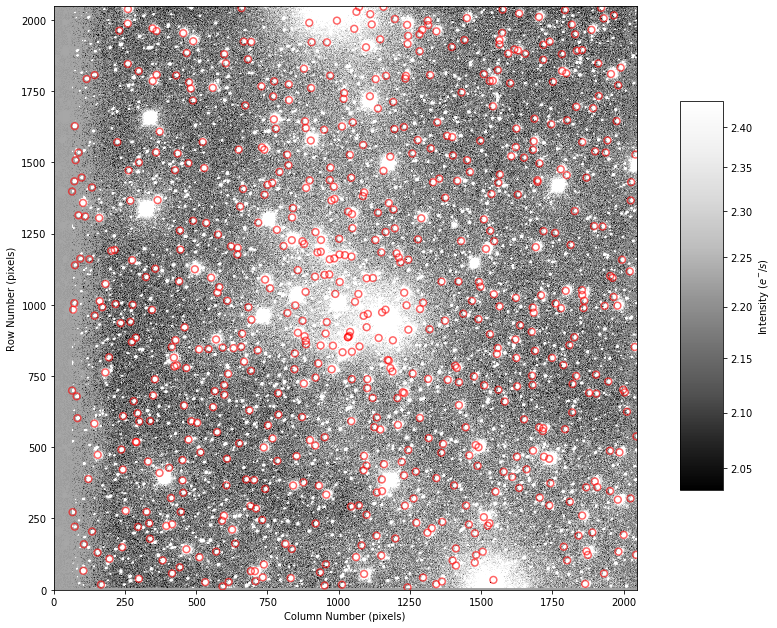

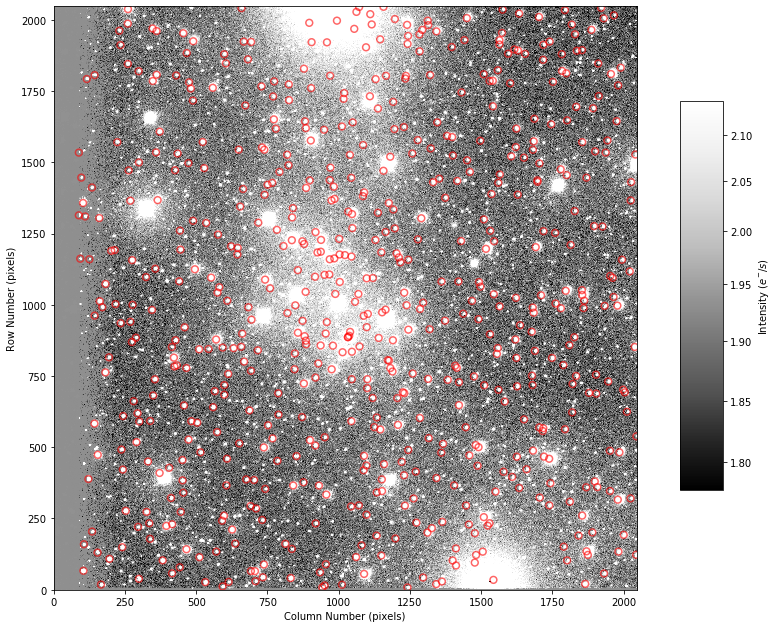

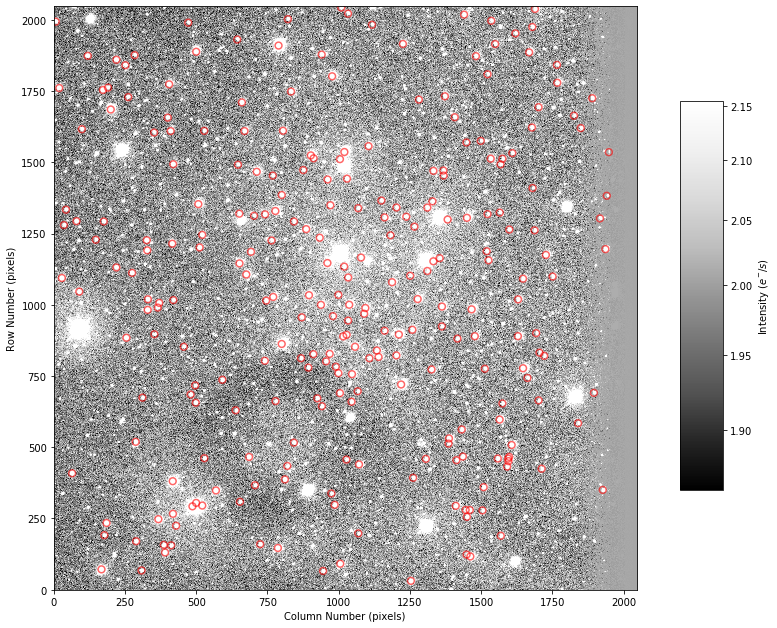

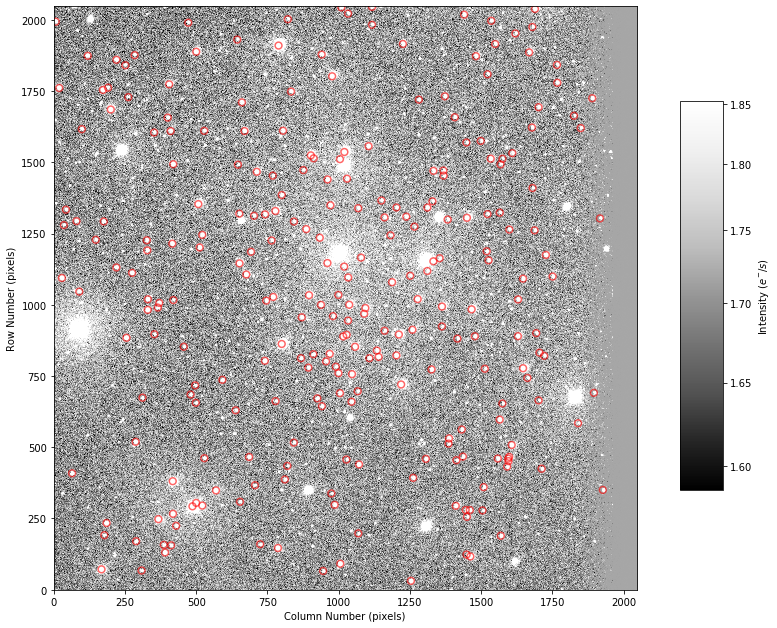

In [25]:
indx_ngc7296_V, indx_ref_ngc7296_V = match_src_ref(refcoord_ngc7296_V, coord_ngc7296_V, srcs_ngc7296_V, img_ngc7296_V)
indx_ngc7296_B, indx_ref_ngc7296_B = match_src_ref(refcoord_ngc7296_B, coord_ngc7296_B, srcs_ngc7296_B, img_ngc7296_B)

indx_k20_V, indx_ref_k20_V = match_src_ref(refcoord_k20_V, coord_k20_V, srcs_k20_V, img_k20_V)
indx_k20_B, indx_ref_k20_B = match_src_ref(refcoord_k20_B, coord_k20_B, srcs_k20_B, img_k20_B)



Now let's calculate the zeropoints for each image.  To compare our objects to those from Pan-STARRS we will need to correct for the effects of airmass.

We start by specifying the atmospheric extinction coefficient for each object.  This says for a typical atmosphere, how much the magnitude changes for an increase in airmass of 1.  We could have measured this using mutliple standard stars but will just assume a cannonical value for now.

In [26]:
def zp_meas(srcs, refcat, indx, indx_ref, hdr):
    kext = {'B': 0.4, 'V': 0.2}
    import numpy.ma as ma

    #this consists of the instrumental magnitude, which is the magnitude, including an airmass correction
    #but without a true zeropoint.  The second term says how the magnitude 
    #m(inst) = -2.5 * log(flux) - (sec z) * k
    instmag = srcs['mag'][indx].data - hdr['AIRMASS'] * kext[hdr['FILTER']]

    #the Pan-STARRS magnitudes for the same objects, as indicated using the indx_ref array
    psmag = refcat[hdr['FILTER']][indx_ref].data

    #calculate the median zeropoint defined as
    #psmag = -2.5 * log(flux) - (sec z) * k + ZP = m(inst) + ZP
    medzp = np.median(psmag - instmag)
    print(hdr['FILTER'],'zeropoint = ', medzp)
    print('Airmass in {} was {}'.format(hdr['FILTER'], hdr['AIRMASS']))
    return medzp

In [27]:
ZPV = zp_meas(srcs_ngc7296_V,refcat_ngc7296_V, indx_ngc7296_V, indx_ref_ngc7296_V,hdr_ngc7296_V)
ZPB = zp_meas(srcs_ngc7296_B,refcat_ngc7296_B, indx_ngc7296_B, indx_ref_ngc7296_B,hdr_ngc7296_B)

ZPk20V = zp_meas(srcs_k20_V,refcat_k20_V, indx_k20_V, indx_ref_k20_V,hdr_k20_V)
ZPk20B = zp_meas(srcs_k20_B,refcat_k20_B, indx_k20_B, indx_ref_k20_B,hdr_k20_B)


V zeropoint =  19.908385022404865
Airmass in V was 1.082708
B zeropoint =  20.775306701844986
Airmass in B was 1.069758
V zeropoint =  20.45541443369038
Airmass in V was 1.144451
B zeropoint =  20.910755989241835
Airmass in B was 1.129516


/home/m044e358/.conda/envs/python3env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Now match the B and V-band catalogs together for this cluster, apply the zeropoints, and plot a CMD!

In [34]:
def make_CMD(img_B,imgwcs_B,srcs_B,imgwcs_V,srcs_V, hdr_B, hdr_V, ZPB, ZPV, radasec = 1.0):
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    import numpy.ma as ma
    kext = {'B': 0.4, 'V': 0.2}
    rad = radasec * u.arcsec
    
    #This uses the WCS to convert the x and y positions of stars in our image to RA-DEC
    radec_stars_B = imgwcs_B.all_pix2world(srcs_B['xcentroid']+1, srcs_B['ycentroid']+1, 1)
    radec_stars_V = imgwcs_V.all_pix2world(srcs_V['xcentroid']+1, srcs_V['ycentroid']+1, 1)
    #this makes an instance of a SkyCoord class containing the RAs and Decs from the B-band
    coord_B = SkyCoord(ra=radec_stars_B[0]*u.deg, dec=radec_stars_B[1]*u.deg)
    coord_V = SkyCoord(ra=radec_stars_V[0]*u.deg, dec=radec_stars_V[1]*u.deg)

    #this calculates the separations.  The "_" are values that are thrown away
    _, sep2d, _ = coord_B.match_to_catalog_sky(coord_V)

    #plot the histograms
    _ = plt.hist(sep2d.arcsec, bins=100, range=(-0.5, 3))
    plt.xlabel('Sep between B and V sources [arcsec]',fontsize=14)
    plt.ylabel('N',fontsize=14)


    #find the indices of the reference and source list that correspond to matching objects such that
    #the first index in each list corresponds to the first matching object
    indx_B, indx_V, d2d, _ = coord_V.search_around_sky(coord_B, rad)
    nmatch = len(indx_B)
    print('Found {}/{} stars within {}'.format(nmatch, len(srcs_B), rad))
    display_image(img_B, srcs=srcs_B[indx_B], calibrated=True)
    
    #make the B and V-band magnitudes
    magB = srcs_B['mag'][indx_B].data + ZPB - hdr_B['AIRMASS'] * kext[hdr_B['FILTER']]
    magV = srcs_V['mag'][indx_V].data + ZPV - hdr_V['AIRMASS'] * kext[hdr_V['FILTER']]
    #print(magB)
    #print(magV)
    #print(magB-magV)

    #plot the CMD!
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(magB-magV, magV, marker = '*', color='red',alpha=0.7)
    ax.set_ylim(19,10)
    ax.set_xlabel('B-V',fontsize=18)
    ax.set_ylabel('V',fontsize=18)
    plt.show


Found 2038/2064 stars within 1.0 arcsec


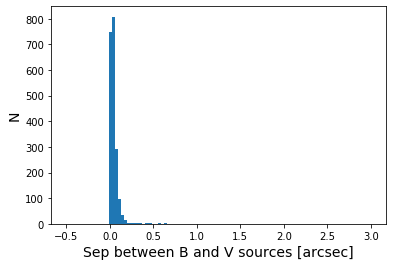

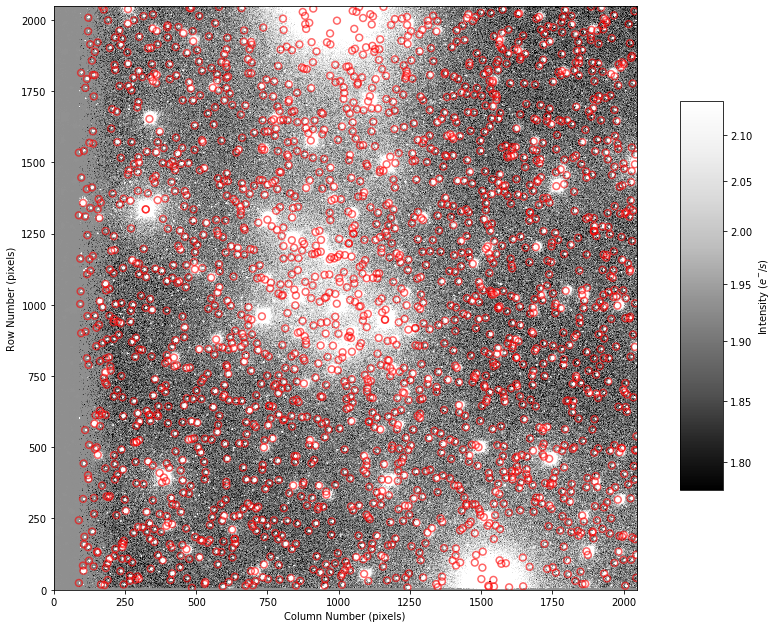

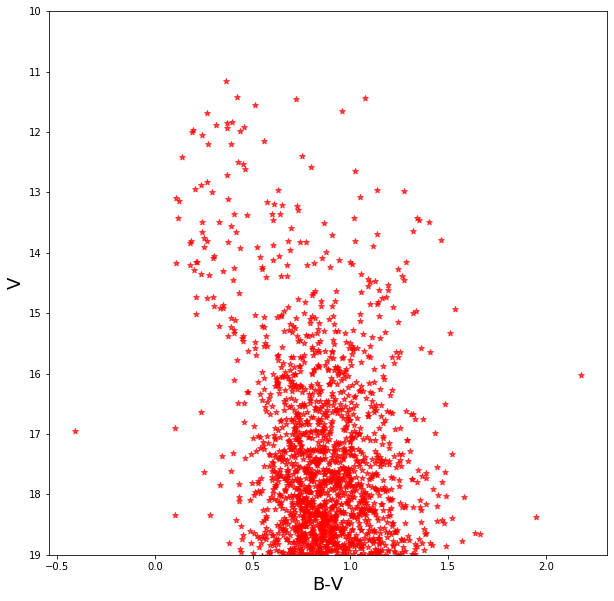

In [35]:
make_CMD(img_ngc7296_B, imgwcs_ngc7296_B, srcs_ngc7296_B,imgwcs_ngc7296_V, srcs_ngc7296_V, hdr_ngc7296_B, hdr_ngc7296_V, ZPB, ZPV, radasec = 1.0)


Found 697/697 stars within 1.0 arcsec


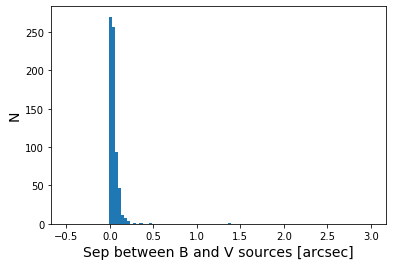

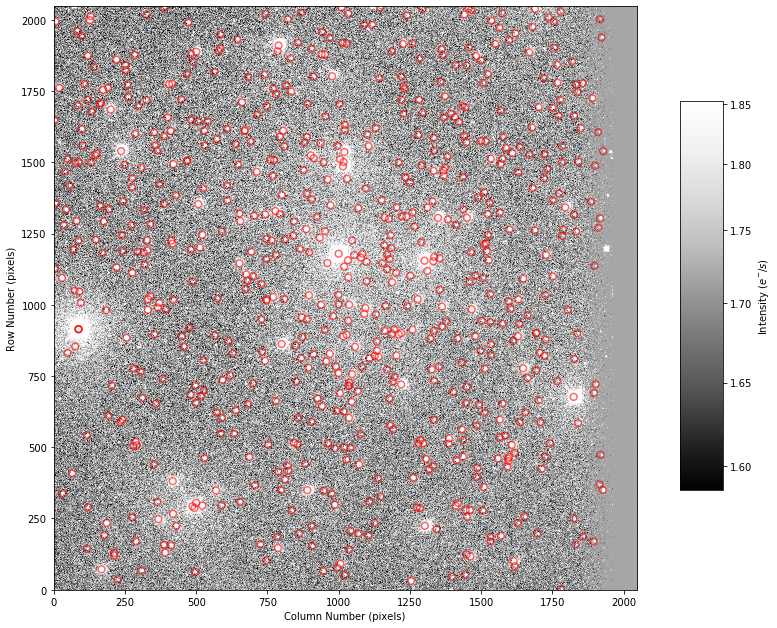

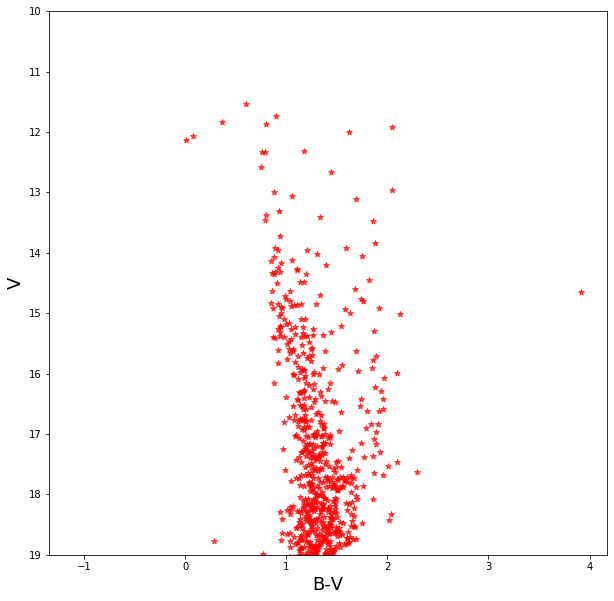

In [36]:
make_CMD(img_k20_B, imgwcs_k20_B, srcs_k20_B,imgwcs_k20_V, srcs_k20_V, hdr_k20_B, hdr_k20_V, ZPk20B, ZPk20V, radasec = 1.0)

The easiest step to check the CMD is to go back to webda and look at their UBV diagram and compare. When this is done we should expect a level of nboise in our CMD due to the milky way stars we are observing, but we should still be able to make out the main sequence curve and pattern of the observed star cluster. Then to more accurately examine the CMD we need to find several bright, corresponding stars between our diagram and the webda UBV diagram and see how well the magnitudes match across the board.

Did not have time to do part 5. Comparing my CMDs to webda I am seeing the same main sequence trend 

